In [ ]:
%%capture --no-stderr
!pip install yfinance itertools statsmodels botorch torchsummary

In [2]:
import pandas as pd
import yfinance as yf
from itertools import combinations
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import os
import math
import torch
import random
import numpy as np
import torch.nn as nn
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement, UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.optim import optimize_acqf
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from torchsummary import summary

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

# Pairs trading strategy

Pairs trading is a market-neutral strategy designed to generate profits regardless of the overall market direction. In pairs trading, you take two simultaneous positions: going long on one asset and short on another. The key requirement is that these assets are highly correlated. The trading signal is derived from the spread or price difference between these two assets. When the spread becomes unusually large compared to historical data, it indicates a temporary divergence, which is expected to correct itself over time and revert to the mean.

Pairs trading is fundamentally a statistical strategy involving hypothesis testing, which assesses whether the observed relationship among multiple financial instruments is statistically significant. It is based on the principle of mean reversion, which assumes that assets deviating significantly from their historical relationship will eventually return to their mean.

### Data downloading

In [3]:
stocks = ['GOOG', 'MSFT', 'AAPL', 'TSLA', 'META', 'NFLX', 'NVDA', 'AMZN', 'BABA', 'INTC', 'PYPL', 'GM', 'PIO', 'C', 'SUP', 'DIS', 'XLI', 'COKE', 'ELP', 'VZ', 'CPK', 'WCN', 'F', 'WOOD']
start_date_trading="2022-01-01"
end_date_trading="2023-12-31"

# Download data from Yahoo Finance
df = yf.download(stocks, start=start_date_trading, end=end_date_trading)['Adj Close']

[*********************100%%**********************]  24 of 24 completed


### Cointegration test and pair selection
The cointegration test determines whether two stocks are sufficiently correlated to apply a pairs trading strategy. The Engle-Granger method is commonly used for this:

* Estimate the coefficients of a linear regression model between the two stocks using ordinary least squares (OLS): $Y = \alpha + \beta X + \varepsilon$.
* Calculate the residuals from this regression model.
* Test the residuals for stationarity using a unit root test, such as the Augmented Dickey-Fuller (ADF) test. If the p-value is below 5%, the residuals are considered stationary with 95% confidence.

If the residuals are stationary, the two stocks are cointegrated. If the residuals are non-stationary, the stocks are not cointegrated.

Correlation measures the degree of linear association between two time series, indicating whether they move together and the strength of this relationship. In contrast, cointegration examines the long-term equilibrium relationship between potentially non-stationary time series. Cointegration suggests that, despite short-term fluctuations, the two series share a common long-term trend. This allows analysts to identify persistent relationships that might be obscured by short-term market volatility.

In [4]:
def coint_custom(X, Y):
    """ Custom function to calculate the result of the Augmented Dickey-Fuller test on the residuals of a linear regression between two time series"""
    X_with_constant= sm.add_constant(X) #we add a constant of ones to be able to catch the alpha parameter of the linear regression
    model = OLS(Y, X_with_constant).fit()
    epsilon = Y - model.predict()
    return adfuller(epsilon)

In [5]:
stock_pairs = list(combinations(df.columns,2)) #list of all stock pairs
pvalues=[]  #list to store the pvalues of the Engle-Granger test using the statsmodels library
pvalues_custom=[]   #list to store the pvalues of the Engle-Granger test using the custom function

# run Engle-Granger test for cointegration on each pair of stocks
for stock1, stock2 in stock_pairs:
    score, pvalue, _ = coint(df[stock1], df[stock2])
    score_custom, pvalue_custom, _, _, _,_ = coint_custom(df[stock1], df[stock2])
    pvalues.append(pvalue)
    pvalues_custom.append(pvalue_custom)

In [6]:
threshold = 0.02
coint_stocks=[] #this will be the list of cointegrated pairs of stocks

for i in range(len(pvalues)):
 # check if the current pair of stocks is cointegrated
 if pvalues[i] < threshold:
    coint_stocks.append(stock_pairs[i])
#coint_stocks

In [7]:
#stock1, stock2= stock_pairs[np.array(pvalues).argmin()]
stock1, stock2= ('MSFT', 'NVDA')    # I have selected this pair of stocks as they are cointegrated

### Trading strategy
For each pair of cointegrated stocks, we calculate the residuals from the linear regression between the two. These residuals represent the spread between the stocks that is not explained by the other stock. Since the stocks are cointegrated, this spread behaves like white noise.

We then standardize the spread using the Z-score: $ z = \frac{X - \mu}{\sigma} $. This standardization allows us to compare values across stocks with different means and standard deviations. The Z-score measures how far the current observation is from the mean in terms of standard deviations. A positive Z-score indicates the deviation is above the mean, while a negative Z-score suggests it is below the mean.

This Z-score serves as a trading signal. When it crosses a certain threshold, it indicates that the stocks are unusually far apart, presenting an opportunity for profit. For instance, if the Z-score falls below -2, it means the spread is unusually negative and might revert to its mean. In this case, we would consider going long on stock 1 and short on stock 2, because if the spread is lower than usual, stock 2 is likely overpriced. When the spread returns to a more typical level (e.g., when the Z-score is above -1), we can close our position.

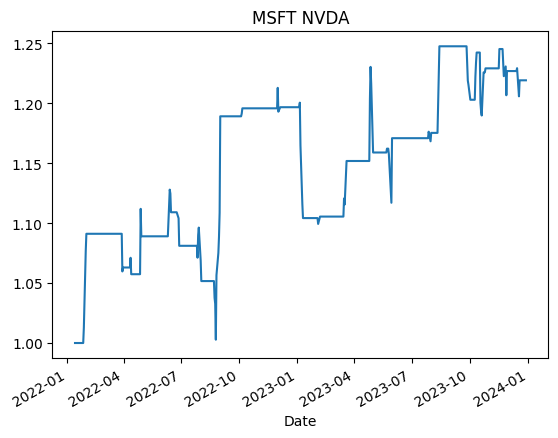

Sharpe ratio:  0.45


In [ ]:
def sharpe_ratio(df, stock1, stock2, entry_threshold=2, exit_threshold=1, riskfree_rate=.04, plot_cum_returns=True):
    """
    Calculate the Sharpe ratio of a pairs trading strategy between two stocks.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the price series of the two stocks.
    stock1 : str
        Name of the first stock in the DataFrame.
    stock2 : str
        Name of the second stock in the DataFrame.
    entry_threshold : float, optional
        Z-score threshold for entering a trade (default is 2).
    exit_threshold : float, optional
        Z-score threshold for exiting a trade (default is 1).
    riskfree_rate : float, optional
        Annualized risk-free rate (default is 0.04).
    plot_cum_returns : bool, optional
        If True, plot the cumulative returns of the strategy (default is True).

    Returns
    -------
    float
        The annualized Sharpe ratio of the pairs trading strategy.

    Notes
    -----
    This function implements a pairs trading strategy by:
    1. Estimating the linear relationship between the two stocks using OLS regression.
    2. Calculating the spread as the residuals of the regression.
    3. Converting the spread to a z-score using a rolling window.
    4. Entering a trade when the z-score exceeds the entry threshold and exiting when it falls below the exit threshold.
    5. Calculating the annualized Sharpe ratio based on the strategy's returns.

    The Sharpe ratio is calculated as:
    \[
    \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
    \]
    where \( R_p \) is the annualized return of the strategy, \( R_f \) is the risk-free rate, and \( \sigma_p \) is the annualized volatility of the strategy's returns.
    """
    Y = df[stock1]
    X = df[stock2]
    X_with_constant = sm.add_constant(X)
    model_ols = OLS(Y, X_with_constant).fit()  # Estimate linear regression coefficients
    spread = Y - model_ols.predict()  # Get the residuals

    # Convert to z-score
    window_size = 10
    spread_pred = spread.rolling(window=window_size)
    zscore = (spread - spread_pred.mean()) / spread_pred.std()

    # The use of a rolling window makes the first window_size-1 numbers unusable
    first_valid_idx = zscore.first_valid_index()
    zscore = zscore[first_valid_idx:]

    # Initialize the daily positions to be zeros
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)

    # Set up positions for each day
    for i in range(1, len(zscore)):
        if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0:
            stock1_position.iloc[i] = 1  # Long stock 1
            stock2_position.iloc[i] = -1  # Short stock 2
        elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0:
            stock1_position.iloc[i] = -1  # Short stock 1
            stock2_position.iloc[i] = 1  # Long stock 2
        elif abs(zscore.iloc[i]) < exit_threshold:  # Exit positions
            stock1_position.iloc[i] = 0
            stock2_position.iloc[i] = 0
        else:  # Maintain positions
            stock1_position.iloc[i] = stock1_position.iloc[i-1]
            stock2_position.iloc[i] = stock2_position.iloc[i-1]

    # Calculate returns for each stock
    stock1_returns = (Y[first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0)
    stock2_returns = (X[first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)

    # Calculate the total returns of the strategy
    total_returns = stock1_returns + stock2_returns

    if plot_cum_returns:
        cumulative_returns = (1 + total_returns).cumprod()
        cumulative_returns.plot(title=f"{stock1} {stock2}")
        plt.ylabel('Cumulative Returns')
        plt.show()

    # Calculate annualized return
    annualized_return = (1 + total_returns).prod() ** (252 / Y[first_valid_idx:].shape[0]) - 1

    # Calculate annualized volatility
    annualized_vol = total_returns.std() * (252 ** 0.5)

    # Avoid division by zero
    if annualized_vol == 0:
        annualized_vol = 1e-10  # Small value to avoid division by zero

    # Calculate Sharpe ratio
    sharpe_ratio_value = (annualized_return - riskfree_rate) / annualized_vol
    return sharpe_ratio_value

# Optimization
Since the initial results are not very satisfactory, we will enhance our algorithm using Bayesian Optimization. Our goal is to find the optimal set of parameters that maximizes profit across multiple backtesting periods to ensure robust performance under various market conditions. Manual parameter selection or grid search can be too time-consuming and computationally expensive, so optimization techniques offer a more efficient alternative by adjusting parameters based on previous results.

We define an objective function for which we seek the global maximum. This function acts as a black-box, meaning we can evaluate it for specific inputs but lack knowledge of its mathematical form or derivatives. Bayesian Optimization balances exploration of new parameter spaces with exploitation of promising results, avoiding the risk of getting stuck in local optima.

Unlike gradient-based methods, Bayesian Optimization is less likely to converge to local optima. It uses a probabilistic model to represent the unknown function and an acquisition function to determine where to sample next. The optimization process iteratively updates the probabilistic model with new sample points and selects the next sampling location based on this updated model. Given that the objective function can be noisy due to varying backtesting periods, Bayesian Optimization effectively manages the exploration-exploitation trade-off. This is achieved through a Gaussian process (GP) that approximates the black-box function and an acquisition function that encodes the trade-off into a scalar value, guiding the sampling process across all candidates in the domain.


* Gaussian Process (GP): Each point of the objective function is treated as a random variable with a normal distribution. By sampling many points, we create a representation of the black-box function. Between two evaluated points, we can define a 95% confidence interval where we are 95% certain that the objective value falls within this range, assuming noise-free and exact observations.

* Acquisition Function: The posterior predictive distribution from the updated Gaussian process provides insights into the objective value and associated uncertainty at unexplored locations. This helps the optimization policy quantify the potential of each candidate location. The acquisition function evaluates each candidate location with a scalar score, and the location with the highest score is chosen for the next sample. It considers both the expected value and uncertainty (variance) at unexplored locations as provided by the Gaussian process. Exploration involves sampling in areas of high uncertainty, while exploitation targets areas where the function value is expected to be high. Common acquisition functions include expected improvement and upper confidence bound. Additionally, there are short-term (myopic) and long-term (nonmyopic) trade-offs. A short-term acquisition function focuses solely on the immediate next step, assuming it’s the final chance to sample, and thus aims to maximize immediate utility. In contrast, a long-term acquisition function uses a multistep lookahead approach, simulating potential future developments to maximize long-term utility.

We apply Bayesian Optimization to find the optimal entry and exit thresholds. For simplicity, we calculate the Sharpe ratio once for a single backtesting period. To reduce observational noise, a more robust approach would be to test over multiple representative backtesting periods and average the Sharpe ratios.

In [9]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Our objective function will be the Sharpe ratio so we create a class for calculating the Sharpe ratio given the entry and exit thresholds (the parameters we want to optimize).

In [10]:
class QTS_OPTIMIZER(nn.Module):
    def __init__(self, ticker_pair, df, function_to_maximize, model_type=None):
        super(QTS_OPTIMIZER, self).__init__()
        self.ticker_pair=ticker_pair
        self.df=df
        self.function_to_maximize = function_to_maximize
        self.model_type= model_type
    
    #function to calculate Sharpe ratio
    def forward(self, entry_threshold, exit_threshold):
        if self.model_type==None:
            return self.function_to_maximize(self.df, self.ticker_pair[0], self.ticker_pair[1], entry_threshold, exit_threshold, plot_cum_returns=False)
        else:
            return self.function_to_maximize(self.df, self.ticker_pair[0], self.ticker_pair[1], entry_threshold, exit_threshold, plot_cum_returns=False, model_type=self.model_type)

In [11]:
qts = QTS_OPTIMIZER([stock1, stock2], df, sharpe_ratio)

Bayesian optimization model works as a machine learning model in the sense that it fine-tunes its weights from a training dataset to match the input distribution. Therefore, we create a training dataset for entry and exit thresholds and their corresponding Sharpe ratio. This is done in the `generate_initial_data` function.

In [ ]:
# set up useful variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
entry_bounds = [0,4] # bounds for the entry threshold
exit_bounds = [0,3.5] # bounds for the exit threshold

def generate_initial_data(n=10):
    """
    Generate an initial training dataset for optimization of pairs trading thresholds.

    Parameters
    ----------
    n : int, optional
        Number of training points to generate (default is 10).

    Returns
    -------
    train_x : torch.Tensor
        Tensor of shape (n, 2) containing the entry and exit thresholds.
        Each row is a pair of (entry_threshold, exit_threshold).
    train_y : torch.Tensor
        Tensor of shape (n, 1) containing the Sharpe ratios corresponding to each pair of thresholds.
    best_observed_value : float
        The maximum Sharpe ratio observed in the generated dataset.

    Notes
    -----
    - The entry and exit thresholds are linearly spaced within their respective bounds.
    - The Sharpe ratios are computed using the `qts` function for each pair of thresholds.
    - The function returns tensors on the specified device and with the specified dtype.
    - This dataset is intended for use in Bayesian optimization or other optimization algorithms.
    """
    # Generate locations randomly distributed within the bounds
    #train_x1 = entry_bounds[0] + (entry_bounds[1] - entry_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    #train_x2 = exit_bounds[0] + (exit_bounds[1] - exit_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    
    # Generate locations linearly distributed within the bounds
    train_x1 = torch.tensor(
        np.linspace(entry_bounds[0], entry_bounds[1], n).reshape(n, 1),
        dtype=dtype,
        device=device
    )
    train_x2 = torch.tensor(
        np.linspace(exit_bounds[0], exit_bounds[1], n).reshape(n, 1),
        dtype=dtype,
        device=device
    )
    train_x = torch.cat((train_x1, train_x2), 1)

    # Obtain the exact value of the objective function and add output dimension
    train_y = []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i], exit_threshold=train_x2[i]))
    train_y = torch.Tensor(train_y).to(dtype).unsqueeze(-1)  # train_y stores the Sharpe ratios

    # Get the current best observed value, i.e., utility of the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value


In [13]:
train_x, train_y, best_observed_value = generate_initial_data()

As previously noted, we can use this training set to optimize the hyperparameters of the Gaussian Process (GP) model to better fit the data. A GP model relies on several hyperparameters during initialization, such as the length scale. Since different GP models come with various hyperparameters, we will use the default settings provided by BoTorch.

In [ ]:
def initialize_model(train_x, train_y):
    """
    Initialize a single-task Gaussian Process (GP) model for Bayesian optimization.

    Parameters
    ----------
    train_x : torch.Tensor
        Input training data of shape (n, d), where `n` is the number of training points
        and `d` is the dimensionality of the input space.
    train_y : torch.Tensor
        Output training data of shape (n, 1), representing the observed values
        corresponding to the input data.

    Returns
    -------
    mll : ExactMarginalLogLikelihood
        The exact marginal log-likelihood object for the GP model.
    model : SingleTaskGP
        The initialized single-task Gaussian Process model.

    Notes
    -----
    - The model uses a Matern kernel and a constant mean function by default.
    - This function is typically used as part of a Bayesian optimization pipeline.
    - The returned `mll` object is used for training the model via maximum likelihood estimation.
    """
    # Create a single-task exact GP model instance
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

We create a function to initialize different models and MLLs. We define a training set for each model because it will be useful in the future.

In [ ]:
beta=.8
num_fantasies=64

def initialize_model_and_mll(n=10):
    """
    Initialize Gaussian Process (GP) models and acquisition functions for Bayesian optimization.

    This function initializes models and acquisition functions for Expected Improvement (EI),
    q-Expected Improvement (qEI), Upper Confidence Bound (UCB), and q-Knowledge Gradient (qKG).

    Parameters
    ----------
    n : int, optional
        Number of initial training points to generate (default is 10).

    Returns
    -------
    train_x_ei : torch.Tensor
        Input training data for the EI model.
    train_y_ei : torch.Tensor
        Output training data for the EI model.
    train_x_qei : torch.Tensor
        Input training data for the qEI model.
    train_y_qei : torch.Tensor
        Output training data for the qEI model.
    train_x_ucb : torch.Tensor
        Input training data for the UCB model.
    train_y_ucb : torch.Tensor
        Output training data for the UCB model.
    train_x_qkg : torch.Tensor
        Input training data for the qKG model.
    train_y_qkg : torch.Tensor
        Output training data for the qKG model.
    best_observed_value : float
        The maximum observed value in the initial training data.
    mll_ei : ExactMarginalLogLikelihood
        Marginal log-likelihood for the EI model.
    model_ei : SingleTaskGP
        Gaussian Process model for EI.
    mll_qei : ExactMarginalLogLikelihood
        Marginal log-likelihood for the qEI model.
    model_qei : SingleTaskGP
        Gaussian Process model for qEI.
    mll_ucb : ExactMarginalLogLikelihood
        Marginal log-likelihood for the UCB model.
    model_ucb : SingleTaskGP
        Gaussian Process model for UCB.
    mll_qkg : ExactMarginalLogLikelihood
        Marginal log-likelihood for the qKG model.
    model_qkg : SingleTaskGP
        Gaussian Process model for qKG.
    EI : ExpectedImprovement
        Expected Improvement acquisition function.
    qEI : qExpectedImprovement
        q-Expected Improvement acquisition function.
    UCB : UpperConfidenceBound
        Upper Confidence Bound acquisition function.
    qKG : qKnowledgeGradient
        q-Knowledge Gradient acquisition function.

    Notes
    -----
    - This function initializes four GP models, each with the same initial training data.
    - The acquisition functions are initialized with the best observed value from the initial data.
    - The UCB acquisition function uses a `beta` parameter, and the qKG acquisition function uses a `num_fantasies` parameter.
    - This function is typically used to set up the initial state for Bayesian optimization with multiple acquisition functions.
    """
    train_x, train_y, best_observed_value = generate_initial_data(n)
    train_x_ei, train_x_qei, train_x_ucb, train_x_qkg = train_x, train_x, train_x, train_x
    train_y_ei, train_y_qei, train_y_ucb, train_y_qkg = train_y, train_y, train_y, train_y

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
    qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(model=model_qkg, num_fantasies=num_fantasies)

    return (
        train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb,
        train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei,
        model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG
    )

train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG = initialize_model_and_mll()

The acquisition function determines the next parameter value to sample by maximizing the function itself. The `optimize_acqf()` function from the `botorch.optim` module handles the search for this maximum value within the defined domain. The new parameter value and its associated score from the objective function are then used as additional training data to refine the GP model and acquisition function for the next iteration.

In [ ]:
# optimize and get new observation

bounds = torch.tensor([[entry_bounds[0], exit_bounds[0]], [entry_bounds[1], exit_bounds[1]]], device=device, dtype=dtype)
BATCH_SIZE = 1 # parallel candidate locations generated in each iteration
NUM_RESTARTS = 10 # number of starting points for multistart optimization
RAW_SAMPLES = 1024 # number of samples for initialization

def optimize_acqf_and_get_observation(acq_func):
    """Optimize an acquisition function and observe new values for the optimization process.

    Parameters
    ----------
    acq_func : callable
        Acquisition function to optimize.

    Returns
    -------
    tuple
        new_x : torch.Tensor
            Optimized candidate points (entry and exit thresholds).
        new_y : torch.Tensor
            Observed value for the optimized candidate points.
    """
    # optimize
    candidates, value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for initialization heuristic
    )
    # observe new values
    new_x = candidates.detach()
    # sample output value
    new_y = qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item())
    # add output dimension
    new_y = torch.Tensor([new_y]).to(dtype).unsqueeze(-1)
    return new_x, new_y

We create a random search strategy that will serve as a baseline for comparison.

In [ ]:
def update_random_observations(best_random, n):
    """Simulate a random policy by drawing new random points, observing their values, and updating the best observed value.

    Parameters
    ----------
    best_random : list
        List tracking the best observed value so far.
    n : int
        Number of random points to generate and evaluate.

    Returns
    -------
    list
        Updated list of the best observed values, including the new maximum if applicable.
    """
    # generate random points
    new_x1 = entry_bounds[0] + (entry_bounds[1] - entry_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    new_x2 = exit_bounds[0] + (exit_bounds[1] - exit_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    new_x = torch.cat((new_x1, new_x2), 1)
    # observe new values
    new_y = qts(entry_threshold=new_x[0,0].item(), exit_threshold=new_x[0,1].item())
    # update the best observed value after observing the new values
    best_random.append(max(best_random[-1], new_y))
    return best_random

We create a function to perform the optimization on several models.

In [ ]:
def optimization(best_observed_value, train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, N_ROUND, n=10):
    """Run the Bayesian optimization loop for multiple acquisition functions and track the best observed values.

    Parameters
    ----------
    best_observed_value : float
        Initial best observed value to start the optimization.
    train_x_ei : torch.Tensor
        Training inputs for Expected Improvement (EI).
    train_y_ei : torch.Tensor
        Training outputs for Expected Improvement (EI).
    train_x_qei : torch.Tensor
        Training inputs for q-Expected Improvement (qEI).
    train_y_qei : torch.Tensor
        Training outputs for q-Expected Improvement (qEI).
    train_x_ucb : torch.Tensor
        Training inputs for Upper Confidence Bound (UCB).
    train_y_ucb : torch.Tensor
        Training outputs for Upper Confidence Bound (UCB).
    train_x_qkg : torch.Tensor
        Training inputs for q-Knowledge Gradient (qKG).
    train_y_qkg : torch.Tensor
        Training outputs for q-Knowledge Gradient (qKG).
    mll_ei : gpytorch.mlls.MarginalLogLikelihood
        Marginal log-likelihood for EI model.
    model_ei : gpytorch.models.ExactGP
        GP model for EI.
    mll_qei : gpytorch.mlls.MarginalLogLikelihood
        Marginal log-likelihood for qEI model.
    model_qei : gpytorch.models.ExactGP
        GP model for qEI.
    mll_ucb : gpytorch.mlls.MarginalLogLikelihood
        Marginal log-likelihood for UCB model.
    model_ucb : gpytorch.models.ExactGP
        GP model for UCB.
    mll_qkg : gpytorch.mlls.MarginalLogLikelihood
        Marginal log-likelihood for qKG model.
    model_qkg : gpytorch.models.ExactGP
        GP model for qKG.
    N_ROUND : int
        Number of optimization rounds to perform.
    n : int, optional
        Number of random points to generate for the random policy (default is 10).

    Returns
    -------
    tuple
        best_random : list
            Best observed values for the random policy.
        best_observed_ei : list
            Best observed values for EI.
        best_observed_qei : list
            Best observed values for qEI.
        best_observed_ucb : list
            Best observed values for UCB.
        best_observed_qkg : list
            Best observed values for qKG.
        best_observed : float
            Overall best observed value across all acquisition functions.
        best_parameters : torch.Tensor
            Parameters corresponding to the overall best observed value.
    """
    # Initialize the best values
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg = [best_observed_value], [best_observed_value], [best_observed_value], [best_observed_value], [best_observed_value]
    # Run N_ROUND rounds of bayesian optimization after the initial random batch
    for iteration in range(1, N_ROUND + 1):
        # Fit GP models to optimize their hyperparameters
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)

        # Instantiate acquisition functions based on the updated GP model instance
        EI = ExpectedImprovement(model=model_ei,best_f=train_y_ei.max())    # best_f is the best function value observed sor far
        qEI = qExpectedImprovement(model=model_qei, best_f=train_y_qei.max())
        UCB = UpperConfidenceBound(model=model_ucb,beta=beta)
        qKG = qKnowledgeGradient(model=model_qkg, num_fantasies=num_fantasies, objective=None)

        # Optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)

        # Update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

        # Update progress
        best_random = update_random_observations(best_random, n)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())
        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)

        # Reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(train_x_ei,train_y_ei)
        mll_qei, model_qei = initialize_model(train_x_qei,train_y_qei)
        mll_ucb, model_ucb = initialize_model(train_x_ucb,train_y_ucb)
        mll_qkg, model_qkg = initialize_model(train_x_qkg,train_y_qkg)
        
    # Get the best observed value and the best parameter
    best_observed_all=np.array(best_observed_ei+best_observed_qei+best_observed_ucb+best_observed_qkg)
    parameters_all = torch.cat([train_x_ei, train_x_qei, train_x_ucb, train_x_qkg], dim=0)
    index_max = best_observed_all.argmax()
    best_observed = best_observed_all[index_max]
    best_parameters = parameters_all[index_max]
        
    return best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg, best_observed, best_parameters

We run several times our optimization function to enhance the performance.

In [20]:
# number of runs to assess standard deviations of different BO loops
N_TRIALS = 2
# number of steps in the outer BO loop
N_ROUND = 2
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []
overall_best=-1
overall_best_parameters=[]

# average over multiple trials
for trial in range(1, N_TRIALS + 1):    
    train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG = initialize_model_and_mll()
    
    # run N_ROUND rounds of bayesian optimization after the initial random batch
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg, best_observed, best_parameters = optimization(best_observed_value, train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, N_ROUND)
            
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)
    
    # get the best observed value and the best parameter
    if(best_observed>overall_best):
        overall_best=best_observed
        overall_best_parameters=best_parameters

In [21]:
overall_best_parameters

tensor([0.6780, 0.5320], dtype=torch.float64)

We put the obtained parameters in the `sharpe_ratio` function.

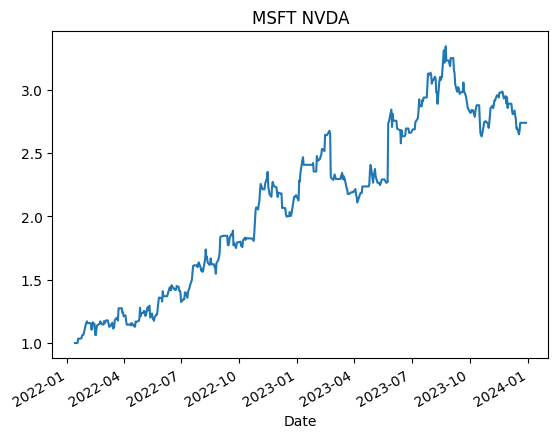

1.7142823867216634

In [25]:
sharpe_ratio(df, stock1, stock2, entry_threshold=overall_best_parameters[0], exit_threshold=overall_best_parameters[1])

We see that the performance of the strategy has greatly improved. As a reminder, the cumulative return for the strategy before optimization was between 1.20 and 1.25 and the Sharpe ration at 0.45.

## References
This notebook is based on the work of Peng Liu in the chapter 8 of his book: Quantitative Trading Strategies Using Python.